In [1]:
using Pkg; Pkg.instantiate(); Pkg.precompile()

Precompiling project...


In [2]:
using Random; Random.seed!(2000);

# Anisotropic models

In this tutorial, we demonstrate how to perform estimation with anisotropic variograms.

## Ellipsoid distance

Anisotropy can be thought of as a deformation of space with an ellipsoid distance. The semiaxes of the ellipsoid determine the preferential directions of the field and their lengths characterize the anisotropy ratio. In GeoStats.jl, all variogram models (empirical and theoretical) support a custom distance function that
can be used to model anisotropy.

A variogram object $\gamma$ can be evaluated as an isotropic model $\gamma(h)$ or as a (possibly) anisotropic model $\gamma(x,y)$. For the Euclidean distance (the default), these two operations match $\gamma(x,y) = \gamma(h)$ in all directions:

In [3]:
using GeoStats

γ = GaussianVariogram()

γ([1.,0.], [0.,0.]) ≈ γ(1.)

true

If instead of an Euclidean ball, we use an ellipsoid with different semiaxes, the operation $\gamma(x,y)$ becomes a function of the direction $x-y$. For example, we can create an ellipsoid distance aligned with the coordinate system where the major semiaxis has twice the size of the minor semiaxis:

In [4]:
using Distances

γaniso = GaussianVariogram(distance=Ellipsoidal([2.,1.],[0.]))

γaniso([1.,0.],[0.,0.]) ≠ γaniso([0.,1.],[0.,0.])

true

## Effects on estimation

Now that we know how to construct anisotropic variograms, we can investigate the effect of varying the anisotropy ratio and alignement angle on estimation results. We start by generating some random data:

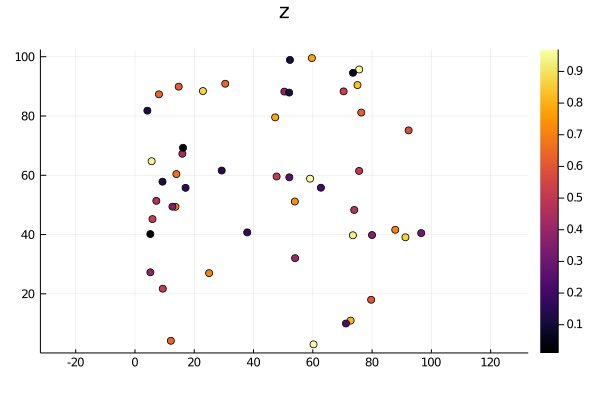

In [5]:
using Plots

dim, nobs = 2, 50

X = 100*rand(dim, nobs)
z = rand(nobs)

sdata = PointSetData(OrderedDict(:z => z), X)

plot(sdata)

and by defining an estimation problem:

In [6]:
sdomain = RegularGrid{Float64}(100,100)
problem = EstimationProblem(sdata, sdomain, :z)

2D EstimationProblem
  data:      50 PointSetData{Float64,2}
  domain:    100×100 RegularGrid{Float64,2}
  variables: z (Float64)

First, we vary the anisotropy ratio with an ellipsoid that is aligned with the coordinate system:

┌ Info: Saved animation to 
│   fn = /home/juliohm/Desktop/GeoStatsTutorials/notebooks/figs/anisotropy_ratio.gif
└ @ Plots /home/juliohm/.julia/packages/Plots/Xnzc7/src/animation.jl:104


Plots.AnimatedGif("/home/juliohm/Desktop/GeoStatsTutorials/notebooks/figs/anisotropy_ratio.gif")
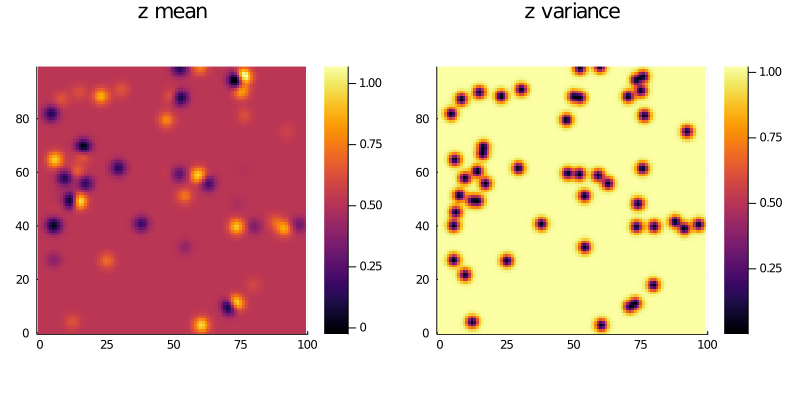

In [7]:
anim = @animate for a in range(1, stop=10., length=10)
    d = Ellipsoidal([a,1.], [0.])
    
    γ = GaussianVariogram(range=5., distance=d)
    
    solution = solve(problem, Kriging(:z => (variogram=γ,)))
    
    plot(solution, size=(800,400))
end
gif(anim, "figs/anisotropy_ratio.gif", fps=1)

Second, we fix the anisotropy ratio and vary the alignment angle:

┌ Info: Saved animation to 
│   fn = /home/juliohm/Desktop/GeoStatsTutorials/notebooks/figs/anisotropy_angle.gif
└ @ Plots /home/juliohm/.julia/packages/Plots/Xnzc7/src/animation.jl:104


Plots.AnimatedGif("/home/juliohm/Desktop/GeoStatsTutorials/notebooks/figs/anisotropy_angle.gif")
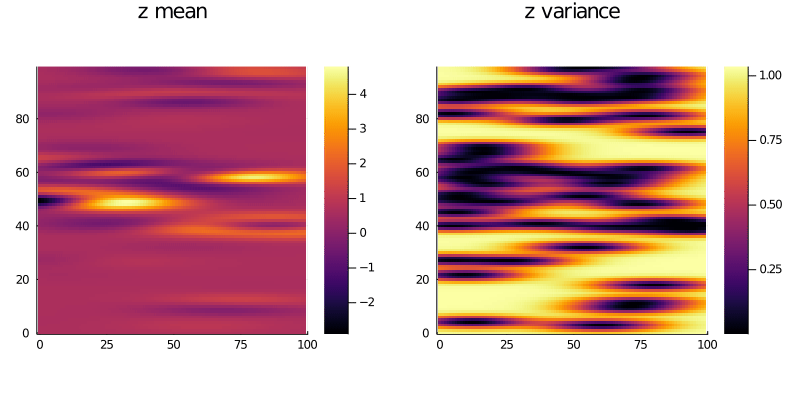

In [8]:
anim = @animate for θ in range(0, stop=2π, length=10)
    d = Ellipsoidal([10.,1.], [θ])
    
    γ = GaussianVariogram(range=5., distance=d)
    
    solution = solve(problem, Kriging(:z => (variogram=γ,)))
    
    plot(solution, size=(800,400))
end
gif(anim, "figs/anisotropy_angle.gif", fps=1)

This experiment can be extended to 3D with the only difference being that ellipsoids therein are defined by 3 semiaxes and 3 angles. For example, the Euclidean distance in 3D can be recovered with a degenerated ellipsoid with equal semiaxes (i.e. sphere):

In [9]:
ellipsoid = Ellipsoidal([1.,1.,1.],[0.,0.,0.])
euclidean = Euclidean()

a, b = rand(3), rand(3)

evaluate(ellipsoid, a, b) ≈ evaluate(euclidean, a, b)

true

## Conclusions

- Geometric anisotropy can be easily modeled with an `Ellipsoidal` distance

- GeoStats.jl recognizes any distance following the [Distances.jl](https://github.com/JuliaStats/Distances.jl) API (i.e. `Metric` types)